# Import libraries

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
import math

# Load Data

In [12]:


data = pd.read_csv("../dataset/raw/Dep_21_CanLine.csv", sep=';', index_col=[0,1])

# X = pd.read_csv('../dataset/inputs/XDataCher_Bvot.csv', sep=';', index_col=[0,1,2,3])
# y = pd.read_csv('../dataset/labels/yDataCher_Bvot.csv', sep=';', index_col=[0,1,2,3])

# yCols = ['target_'+c for c in y.columns]
# XCols = X.columns
# y.columns = yCols

# X.sort_values(['CODCAN', 'CODSUBCOM'])
data.columns

Index(['Libellé du Canton', 'Inscrits', 'Abstentions', 'Votants', 'Blancs',
       'Nuls', 'Exprimés', 'Binôme_0', 'Nuance_0', 'Voix_0', '%Voix/Exp_0',
       '%Voix/Ins_0', 'Binôme_1', 'Nuance_1', 'Voix_1', '%Voix/Exp_1',
       '%Voix/Ins_1', 'Binôme_2', 'Nuance_2', 'Voix_2', '%Voix/Exp_2',
       '%Voix/Ins_2', 'Binôme_3', 'Nuance_3', 'Voix_3', '%Voix/Exp_3',
       '%Voix/Ins_3', 'Binôme_4', 'Nuance_4', 'Voix_4', '%Voix/Exp_4',
       '%Voix/Ins_4', 'Binôme_5', 'Nuance_5', 'Voix_5', '%Voix/Exp_5',
       '%Voix/Ins_5', 'Binôme_6', 'Nuance_6', 'Voix_6', '%Voix/Exp_6',
       '%Voix/Ins_6', 'Binôme_7', 'Nuance_7', 'Voix_7', '%Voix/Exp_7',
       '%Voix/Ins_7', 'Binôme_8', 'Nuance_8', 'Voix_8', '%Voix/Exp_8',
       '%Voix/Ins_8', 'Binôme_9', 'Nuance_9', 'Voix_9', '%Voix/Exp_9',
       '%Voix/Ins_9', 'Binôme_10', 'Nuance_10', 'Voix_10', '%Voix/Exp_10',
       '%Voix/Ins_10', 'Binôme_11', 'Nuance_11', 'Voix_11', '%Voix/Exp_11',
       '%Voix/Ins_11', 'Binôme_12', 'Nuance_12', 'Voix_12'

In [13]:
for i in range(getNbBinomes(data)):
    data['%Voix/Ins_'+str(i)] = (100 * data['Voix_'+str(i)] / data['Inscrits']).round(2)

cols = ['Libellé du Canton', 'Inscrits', 'Abstentions', 'Votants', 'Blancs', 'Nuls', 'Exprimés'] + [h+'_'+str(i) for i in range(getNbBinomes(data)) for h in ['Binôme', 'Nuance', 'Voix', '%Voix/Exp', '%Voix/Ins']]
data = data.reindex(cols, axis=1)

data.to_csv("../dataset/raw/Dep_21_CanLine.csv", sep=';')

In [6]:
def getNbBinomes(data):
    return len([header for header in data.columns if "Binôme" in header])

def getAllNuances(data, colNuance='CODNUA', fmt='exploded'):
    if fmt not in ['exploded', 'line']:
        raise ValueError("format parameter must be 'exploded' or 'line'")
    
    if fmt == 'exploded':
        nuances = data[colNuance].unique()
    
    if fmt == 'line':
        nuances = np.array([])
        nuances_tmp = data[colNuance].fillna(0)
        for c in nuances_tmp:
            nuances = np.append(nuances, nuances_tmp[c])
        nuances = np.unique(nuances[nuances!=0])
    
    return sorted(nuances)


In [40]:
def explodeLines(data):
    initdf = data[['Code du département', 'Libellé du département', 'Code du canton', 
            'Libellé du canton', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
            '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
            '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot']]
    headers = ['N°Panneau', 'Nuance', 'Binôme', 'Sièges', 'Voix', '% Voix/Ins', '% Voix/Exp']
    
    df = pd.DataFrame()
    for i in range(getNbBinomes(data)):
        partidf = data[[h+'.'+str(i) if i!=0 else h for h in headers]]
        partidf = pd.concat([initdf, partidf], axis=1)
        partidf.columns = pd.Index(initdf.columns.values.tolist() + headers)
        df = pd.concat([df, partidf])
    
    # Remove useless rows
    df = df.dropna(how='all', subset=headers)
    
    return df


def prepareInputDataExploded(data):
    tmp = data[['Code du département', 'Code du canton', 'Inscrits', 'Exprimés', 'Votants', '% Abs/Ins', '% Exp/Vot', *[h+'.'+str(i) if i!=0 else h for i in range(getNbBinomes(data)) for h in ['Nuance', 'Voix']] ]].copy()

    # #dictionnaire des duels
    # duels = dict()
    # count=0
    # for dep in dataCanton['Code du département'].unique():
    #     duels[str(dep)], count = getDuels(dataCanton, dep, count=count)
    #     if duels[str(dep)]==[]:
    #         print('empty list for dep : ', dep)

    # #dictionnaire optimisé
    # optDuels = optimizeDuelDict(duels)
    # winnersT1 = [duel.split(':') for duel in list(optDuels.keys()) if len(duel.split(':'))<2]

    # correction = [str(i) for i in range(1,10)]
    # for winner in winnersT1:
    #      for dep, can in optDuels[winner[0]]:
    #         if dep in correction:
    #             tmp = tmp.loc[~((tmp['CODDPT']=='0'+dep) & (tmp['CODCAN']==int(can)))]
    #         else:
    #             tmp = tmp.loc[~((tmp['CODDPT']==dep) & (tmp['CODCAN']==int(can)))]
    
    # Compute missing data
    tmp['NBRBLCNUL'] = tmp['Votants'] - tmp['Exprimés']
    tmp['%BLCNUL/VOT'] = tmp['NBRBLCNUL'] / tmp['Votants']

    nuances = getAllNuances(data, colNuance=['Nuance.'+str(i) if i!=0 else 'Nuance' for i in range(getNbBinomes(data))], fmt="line")
    statsFeatures = ['Inscrits', 'Exprimés', '% Abs/Ins', '%BLCNUL/VOT', '% Exp/Vot']
    idFeatures = ['Code du département', 'Code du canton']

    exprimes = tmp[idFeatures + ['Exprimés']].drop_duplicates().sort_values(idFeatures)['Exprimés']
    stats = tmp[idFeatures + statsFeatures].drop_duplicates()[statsFeatures]
    ids = tmp[idFeatures].drop_duplicates()

    # Create [%Voix] and fill it
    voix = pd.DataFrame(0, index=data.index, columns=nuances)
    for parti in nuances:
        voix.loc[data['Nuance']==parti, parti] = tmp[tmp['Nuance']==parti]['Voix']
    voix = pd.concat([tmp[idFeatures], voix], axis=1).groupby(idFeatures).sum()[nuances]
    voix.index = exprimes.index

    # Concat with computed stats and divide almost everything by Exprimés
    voix = voix.divide(exprimes, axis=0)
    X = pd.concat([stats, voix], axis=1)
    X.index = pd.MultiIndex.from_frame(ids)
    return X.sort_values(idFeatures)


In [46]:

df = prepareInputDataExploded(explodeLines(dataT1Can))
year = '2015'
df.to_csv('../dataset/inputs/XDataFR_'+year+'_Can.csv')
df


Inscrits  Exprimés  % Abs/Ins  \
Code du département Code du canton                                  
1                   1                  19027      9058      50.39   
                    2                  16739      8492      46.72   
                    3                  12773      5520      55.04   
                    4                  16868      9184      43.20   
                    5                  19929      9384      51.70   
...                                      ...       ...        ...   
ZM                  9                   9435      5973      33.81   
                    10                  7360      4571      34.33   
                    11                  3793      2335      36.12   
                    12                  9604      5920      35.81   
                    13                  7336      4802      32.97   

                                    %BLCNUL/VOT  % Exp/Vot    BC-COM  \
Code du département Code du canton                                     
1                   1                  0.040364      95.96  0.075513   
                    2                  0.047875      95.21  0.000000   
                    3                  0.038830      96.12  0.000000   
                    4                  0.041436      95.86  0.079813   
                    5                  0.025039      97.50  0.049979   
...                                         ...        ...       ...   
ZM                  9                  0.043555      95.64  0.000000   
                    10                 0.054211      94.58  0.000000   
                    11                 0.036319      96.37  0.000000   
                    12                 0.039740      96.03  0.000000   
                    13                 0.023388      97.66  0.000000   

                                      BC-DIV  BC-DLF    BC-DVD    BC-DVG  ...  \
Code du département Code du canton                                        ...   
1                   1               0.000000     0.0  0.000000  0.000000  ...   
                    2               0.000000     0.0  0.000000  0.000000  ...   
                    3               0.000000     0.0  0.000000  0.000000  ...   
                    4               0.000000     0.0  0.000000  0.000000  ...   
                    5               0.000000     0.0  0.000000  0.000000  ...   
...                                      ...     ...       ...       ...  ...   
ZM                  9               0.000000     0.0  0.086891  0.264859  ...   
                    10              0.251367     0.0  0.046161  0.000000  ...   
                    11              0.000000     0.0  0.623126  0.292934  ...   
                    12              0.000000     0.0  0.289358  0.274662  ...   
                    13              0.043315     0.0  0.000000  0.152020  ...   

                                      BC-MDM  BC-PG  BC-RDG    BC-SOC  BC-UC  \
Code du département Code du canton                                             
1                   1               0.000000    0.0     0.0  0.000000    0.0   
                    2               0.000000    0.0     0.0  0.000000    0.0   
                    3               0.000000    0.0     0.0  0.000000    0.0   
                    4               0.000000    0.0     0.0  0.000000    0.0   
                    5               0.000000    0.0     0.0  0.000000    0.0   
...                                      ...    ...     ...       ...    ...   
ZM                  9               0.000000    0.0     0.0  0.000000    0.0   
                    10              0.231459    0.0     0.0  0.000000    0.0   
                    11              0.000000    0.0     0.0  0.000000    0.0   
                    12              0.000000    0.0     0.0  0.000000    0.0   
                    13              0.000000    0.0     0.0  0.245314    0.0   

                                       BC-UD    BC-UDI     BC-UG    BC-UMP  \
Code du département Code du 

## Select data

In [ ]:
np.random.seed(42)

trainset = pd.DataFrame()
testset = pd.DataFrame()

for canton in X.index.get_level_values('CODCAN'):
    XFiltered = X[X.index.get_level_values('CODCAN')==canton]
    yFiltered = y[y.index.get_level_values('CODCAN')==canton]
    
    XFiltered.sample(frac=1) # shuffle

    nBurTrain = math.ceil(len(XFiltered) * 0.5)
    X_train_canton = XFiltered[:nBurTrain]
    X_test_canton = XFiltered[nBurTrain:]

    colsName = [c+'.'+str(i) for i in range(len(X_train_canton)) for c in X_train_canton.columns.tolist()]
    trainRow = X_train_canton.stack()
    testRow = X_test_canton.stack()
    testRow = testRow.append(pd.Series([0]*(len(trainRow)-len(testRow)), dtype='float64'))
    trainRow.index = colsName
    testRow.index = colsName
    trainRow.name = canton
    testRow.name = canton
    trainset = trainset.append(trainRow)
    testset = testset.append(testRow)

testset = testset[colsName].drop_duplicates().sort_index().fillna(0)
trainset = trainset[colsName].drop_duplicates().sort_index().fillna(0)

In [ ]:
print(trainset.shape, y.shape)
trainset

# Build Model

## Initialization

In [84]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(160,)))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(20, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training and evaluation

Train: 1.000, Test: 0.842


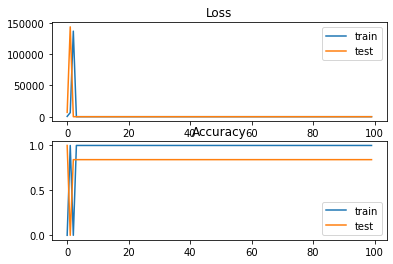

In [85]:
history = model.fit(trainset, y, batch_size=32, validation_data=(testset, y), epochs=100, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainset, y, verbose=0)
_, test_acc = model.evaluate(testset, y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## Save Model

In [ ]:
model.save('models/Bvot-Canton_Cher')